In [19]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Vodafone Score WOE\Vodafone Pillar Analysis-Exi SC")

In [21]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\export.csv")

In [22]:
df.shape

(215296, 11)

In [23]:
df.dropna(subset = ["CREDIT_SCORE"], inplace = True)

In [24]:
df.shape

(31389, 11)

In [25]:
df.head()

,SKP_CREDIT_CASE,DATE_DECISION,CREDIT_SCORE,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,GENERALMODELLG,GENERALMODELLOGREG,CREDIT_SCORE_WOE
2,283490648,2019-11-17,0.048168,0,0,0,0,0,0.019463,0.023289,-0.0457
3,283490648,2019-11-17,0.048168,0,0,0,0,0,0.019463,0.023289,-0.0457
6,283491295,2019-11-17,0.022407,0,0,0,0,0,0.008481,0.019850,-0.0457
7,283491295,2019-11-17,0.022407,0,0,0,0,0,0.008481,0.019850,-0.0457
12,283492911,2019-11-17,0.008795,0,0,0,0,0,0.017823,0.022516,0.5066


In [26]:
df.columns

Index(['SKP_CREDIT_CASE', 'DATE_DECISION', 'CREDIT_SCORE', 'RISK_FPD30',
       'RISK_FSPD30', 'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60',
       'GENERALMODELLG', 'GENERALMODELLOGREG', 'CREDIT_SCORE_WOE'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

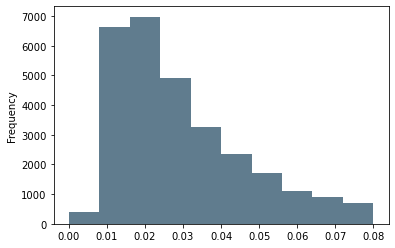

In [27]:
# Check distribution of scores
pd.Series(df['GENERALMODELLOGREG']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [28]:
hcc_score='GENERALMODELLOGREG'

# HCC score Gini         
metric_auc_hcc = metrics.roc_auc_score(df['RISK_FSTQPD30'], df[hcc_score])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.3950603351005122


In [31]:
df["DATE_DECISION"] = pd.to_datetime(df["DATE_DECISION"],format ='%Y-%m-%d')

df["MONTH"]= df["DATE_DECISION"].dt.strftime("%y-%m")

In [32]:
df_summ = df.groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

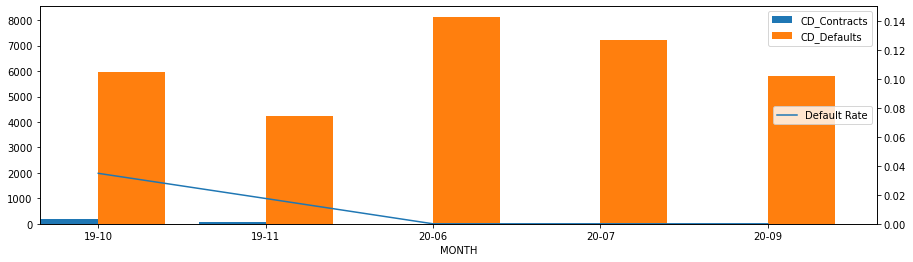

In [33]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [34]:
#MOM Gini Risk Score
for x in df["MONTH"].unique():
    try:   
        metric_auc_hcc = metrics.roc_auc_score(df[df["MONTH"]==x]['RISK_FSTQPD30'], df[df["MONTH"]==x][hcc_score])
        gini_hcc_only = 2 * metric_auc_hcc - 1
        print(x ,gini_hcc_only)  
    except:
        print("ERROR")

19-11 0.4023937482150741
19-10 0.43440993623095614
ERROR
ERROR
ERROR


In [35]:
df["GENERALMODELLOGREG_LOG"] = np.log((df["GENERALMODELLOGREG"] + 1e-10).divide(1 - (df["GENERALMODELLOGREG"] + 1e-10)))

In [36]:
df["COMBINED_SCORE_WITH_VODA"] = df["GENERALMODELLOGREG_LOG"] - 1*df["CREDIT_SCORE_WOE"]

In [37]:
df = df.rename(columns = {'CREDIT_SCORE_WOE':'VODA_SCORE_WOE','CREDIT_SCORE':'VODA_SCORE'})

# Model Evaluation : FSTQPD30

In [38]:
TIME_DECISION_DATE = "DATE_DECISION"
FINAL_SCORE = "VODA_SCORE_WOE"
RISK_SCORE = "GENERALMODELLOGREG"
COMBINED_SCORE = "COMBINED_SCORE_WITH_VODA"
TARGET = "RISK_FSTQPD30"
TARGET1 = "RISK_FSTQPD30"
# PREDICTOR_LIST = ['G_RISK_FSTQPD30_SCORE', 'G_RISK_FPD10_SCORE','G_DEFAULT_FLAG_CHANGE_1']
# df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

# GINI

### Gini Chart

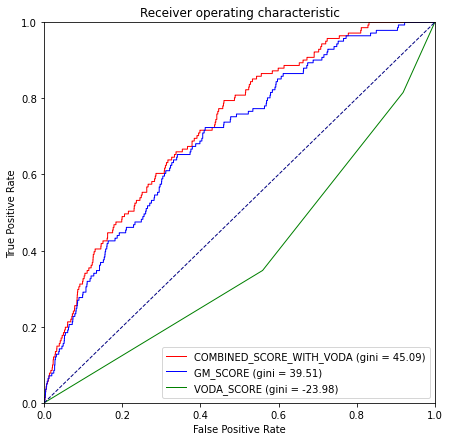

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[TARGET],df[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_VODA (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='GM_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='VODA_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [40]:

gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR
ERROR
ERROR


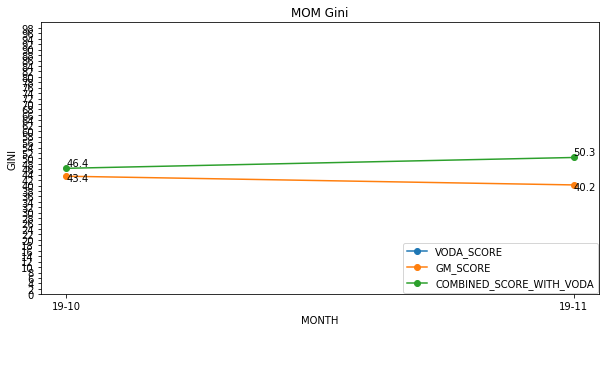

In [41]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["VODA_SCORE_WOE"], marker='o', scaley = False, label = "VODA_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "GM_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE_WITH_VODA"], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_VODA")

for i, txt in enumerate(gini_df["VODA_SCORE_WOE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["VODA_SCORE_WOE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE_WITH_VODA"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE_WITH_VODA"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini")
plt.show()

# Model Evaluation : FSTPD30

In [42]:
TIME_DECISION_DATE = "DATE_DECISION"
FINAL_SCORE = "VODA_SCORE_WOE"
RISK_SCORE = "GENERALMODELLOGREG"
COMBINED_SCORE = "COMBINED_SCORE_WITH_VODA"
TARGET = "RISK_FSTPD30"
TARGET1= "RISK_FSTPD30"
# PREDICTOR_LIST = ['G_RISK_FSTQPD30_SCORE', 'G_RISK_FPD10_SCORE','G_DEFAULT_FLAG_CHANGE_1']
# df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

# GINI

### Gini Chart

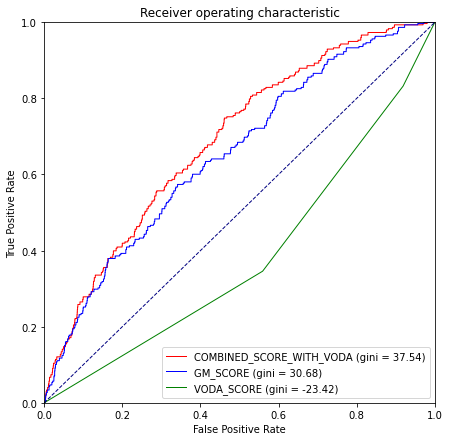

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[TARGET],df[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_VODA (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='GM_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='VODA_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [44]:
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR
ERROR


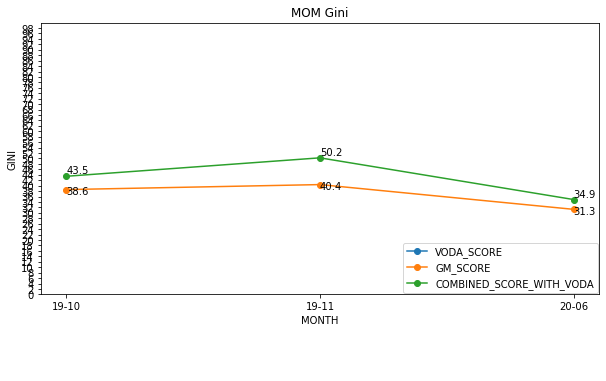

In [45]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["VODA_SCORE_WOE"], marker='o', scaley = False, label = "VODA_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "GM_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE_WITH_VODA"], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_VODA")

for i, txt in enumerate(gini_df["VODA_SCORE_WOE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["VODA_SCORE_WOE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE_WITH_VODA"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE_WITH_VODA"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini")
plt.show()

# Model Evaluation : FSPD30

In [46]:
TIME_DECISION_DATE = "DATE_DECISION"
FINAL_SCORE = "VODA_SCORE_WOE"
RISK_SCORE = "GENERALMODELLOGREG"
COMBINED_SCORE = "COMBINED_SCORE_WITH_VODA"
TARGET = "RISK_FSPD30"
TARGET1= "RISK_FSPD30"
# PREDICTOR_LIST = ['G_RISK_FSTQPD30_SCORE', 'G_RISK_FPD10_SCORE','G_DEFAULT_FLAG_CHANGE_1']
# df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

# GINI

### Gini Chart

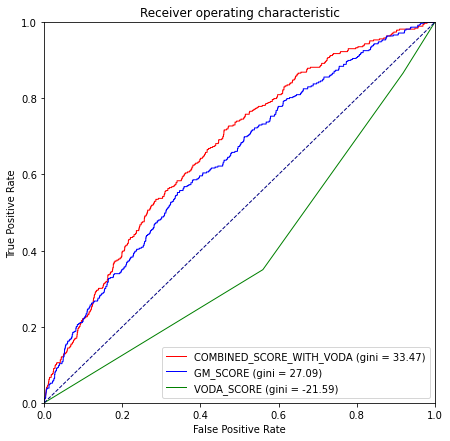

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[TARGET],df[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_VODA (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='GM_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='VODA_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [48]:
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


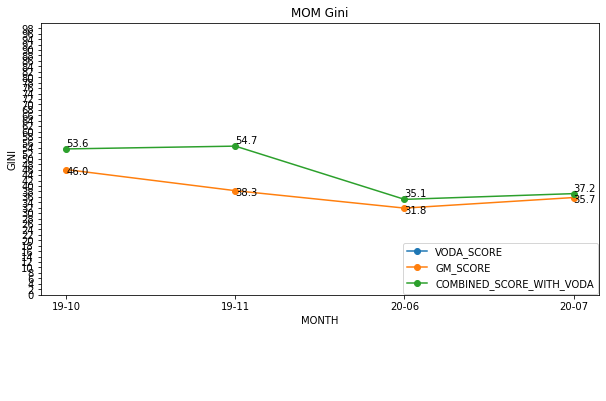

In [49]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["VODA_SCORE_WOE"], marker='o', scaley = False, label = "VODA_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "GM_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE_WITH_VODA"], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_VODA")

for i, txt in enumerate(gini_df["VODA_SCORE_WOE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["VODA_SCORE_WOE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE_WITH_VODA"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE_WITH_VODA"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini")
plt.show()

# Model Evaluation : FPD30

In [50]:
TIME_DECISION_DATE = "DATE_DECISION"
FINAL_SCORE = "VODA_SCORE_WOE"
RISK_SCORE = "GENERALMODELLOGREG"
COMBINED_SCORE = "COMBINED_SCORE_WITH_VODA"
TARGET = "RISK_FPD30"
TARGET1= "RISK_FPD30"
# PREDICTOR_LIST = ['G_RISK_FSTQPD30_SCORE', 'G_RISK_FPD10_SCORE','G_DEFAULT_FLAG_CHANGE_1']
# df["MONTH"] = df[TIME_DECISION_DATE].dt.strftime("%y-%m")

# GINI

### Gini Chart

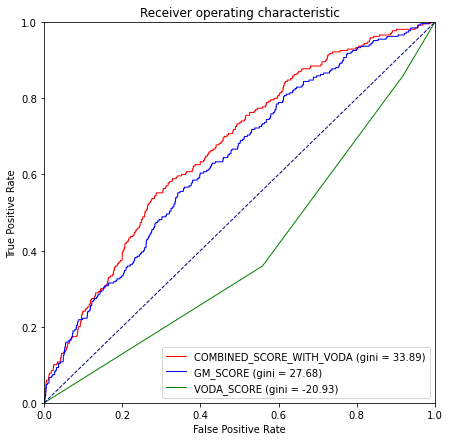

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fig = plt.figure(figsize = (7,7))
ax1 = fig.add_subplot(1, 1, 1)

lw = 1
fpr, tpr, thresholds = roc_curve(df[TARGET],df[COMBINED_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='red', lw=lw, label='COMBINED_SCORE_WITH_VODA (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[RISK_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='blue', lw=lw, label='GM_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

fpr, tpr, thresholds = roc_curve(df[TARGET],df[FINAL_SCORE])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='green', lw=lw, label='VODA_SCORE (gini = %0.2f)' % ((2*roc_auc-1)*100))

ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### MOM GINI

In [52]:
gini_dic = {}
for x in df["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if FINAL_SCORE not in gini_dic: 
            gini_dic[FINAL_SCORE] = []
        if RISK_SCORE not in gini_dic: 
            gini_dic[RISK_SCORE] = []
        if COMBINED_SCORE not in gini_dic: 
            gini_dic[COMBINED_SCORE] = []
        
        gini_dic[FINAL_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][FINAL_SCORE])-1)*100)
        gini_dic[RISK_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][RISK_SCORE])-1)*100)
        gini_dic[COMBINED_SCORE].append((2*roc_auc_score(df[df["MONTH"]==x][TARGET1],df[df["MONTH"]==x][COMBINED_SCORE])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in PREDICTOR_LIST:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             gini_dic[y].append(((2*roc_auc_score(df[df["MONTH"]==x]["RISK_FSTQPD30"],df[df["MONTH"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)


ERROR


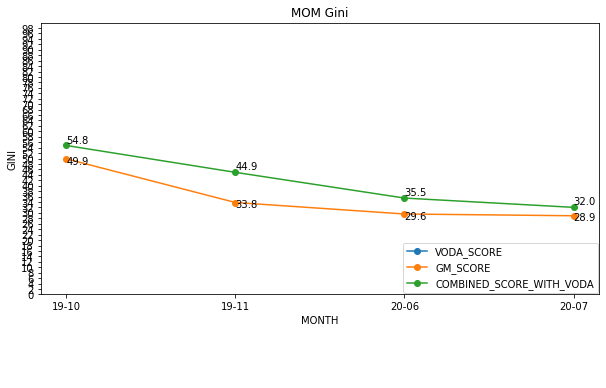

In [53]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["VODA_SCORE_WOE"], marker='o', scaley = False, label = "VODA_SCORE")
ax1.plot(gini_df["MONTH"],gini_df[RISK_SCORE], marker='o', scaley = False, label = "GM_SCORE")
ax1.plot(gini_df["MONTH"],gini_df["COMBINED_SCORE_WITH_VODA"], marker='o', scaley = False, label= "COMBINED_SCORE_WITH_VODA")

for i, txt in enumerate(gini_df["VODA_SCORE_WOE"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["VODA_SCORE_WOE"][i]+0.9))
for i, txt in enumerate(gini_df[RISK_SCORE]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df[RISK_SCORE][i]-1.9))
for i, txt in enumerate(gini_df["COMBINED_SCORE_WITH_VODA"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["COMBINED_SCORE_WITH_VODA"][i]+0.9))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,100)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,100,2))
ax1.set_title("MOM Gini")
plt.show()